## Project

In [52]:
import pandas as pd
import numpy as np
import requests
import os
import xarray as xr
#from netCDF4 import Dataset
import tempfile
from scipy.spatial.distance import cdist
from tqdm import tqdm
from math import radians, cos, sin, asin, sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import ensemble
import matplotlib.pyplot as plt
import shap
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

### 1. Data Collection

#### 1.1 Biomass data

Spatio-temporal data for walleye pollock in the Gulf of Alaska extracted from the NOAA Fisheries website: https://apps-st.fisheries.noaa.gov/dismap/DisMAP.html#single-species-distributions

In [3]:
wp_gulf_alaska = pd.read_csv("wp_gulf_alaska.csv")
wp_gulf_alaska.head()

,HaulID,Stratum,LAT,LON,Depth,Year,wtcpue
0,021-198403-001,350,55.98767,-134.59517,346,1984,0.0000
1,021-198403-002,251,55.63200,-134.22900,225,1984,4.7482
2,021-198403-003,151,55.21450,-133.88733,117,1984,1.0413
3,021-198403-006,151,55.13300,-133.87100,141,1984,1.3450
4,021-198403-007,151,55.12550,-134.00167,170,1984,0.2030


Columns:
- HaulID / Stratum: characterizes the survey expedition and catch throw.
- LAT / LON: Latitude and Longitude of survey catch
- Depth: Sea depth measured in meters below sea level.
- Year: No other timestamp is provided. However, documentation specify that all surveys have been conducted during summer months.
- wtcpue: survey catch measured in kg per ha.


In [4]:
wp_gulf_alaska = wp_gulf_alaska.rename(columns={"HaulID": "haul_id", "Stratum": "stratum", "LAT": "lat", "LON": "lon", "Depth":'depth', "Year": "year"})
wp_gulf_alaska['year'] = wp_gulf_alaska['year'].astype('int64')
wp_gulf_alaska.head()

,haul_id,stratum,lat,lon,depth,year,wtcpue
0,021-198403-001,350,55.98767,-134.59517,346,1984,0.0000
1,021-198403-002,251,55.63200,-134.22900,225,1984,4.7482
2,021-198403-003,151,55.21450,-133.88733,117,1984,1.0413
3,021-198403-006,151,55.13300,-133.87100,141,1984,1.3450
4,021-198403-007,151,55.12550,-134.00167,170,1984,0.2030


#### 1.2 Oceanographic data

We web-scrape temperature and salinity geospatial data from HyCOM (Hybrid Coordinate Ocean Model) using their NCSS request URL. Since there is too much data, we have decided to only get a sample from the first day of each summer month (July 1st, August 1st and September 1st). Of course, including more points should improve our model. Then again, we don't have a timestamp associated with each survey, just the year.

We will extract data from this geographic region:
- North limit: 60.32
- South limit: 52.41
- West limit: -170
- East limit: -132.5

Unfortunately, we do not have data prior to 1995. 

In [5]:
# Define the list of years and months
year_list = [1996, 1999, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019]
month_list = [7, 8, 9]
this_folder = os.getcwd()
data_folder = this_folder + '\\temp' # '\\temp' on a windows machine

if not os.path.exists('ocean_data.csv'):
  # create data folder if it doesn't exists 
  if not os.path.exists(data_folder):
    os.mkdir(data_folder)
  
  # Create an empty DataFrame to store the results
  df_all = pd.DataFrame()

  # Loop over each desired year and month, and add a progress bar
  for year in year_list:
      for month in tqdm(month_list, desc=f'{year}'):
          # Define the date string
          date_str = f'{year}-{month:02d}-01T09:00:00Z'
          # Define the URL with the fixed parameters
          if year <=2015:
              url = "https://ncss.hycom.org/thredds/ncss/GLBv0.08/expt_53.X/data/"+str(year)+"?var=salinity_bottom&var=water_temp_bottom&north=60.32&west=-170&east=-132.5&south=52.41&horizStride=1&vertCoord=&accept=netcdf4"
          elif year == 2017:
              url = "https://ncss.hycom.org/thredds/ncss/GLBv0.08/expt_57.7?var=salinity_bottom&var=water_temp_bottom&north=60.32&west=-170&east=-132.5&south=52.41&horizStride=1&vertCoord=&accept=netcdf4"
          else:
              url = "https://ncss.hycom.org/thredds/ncss/GLBv0.08/expt_93.0/ts3z?var=salinity_bottom&var=water_temp_bottom&north=60.32&west=-170&east=-132.5&south=52.41&horizStride=1&vertCoord=&accept=netcdf4"
          
          my_file = os.path.join(this_folder, 'temp', f'example-{date_str[:10]}.nc4')
          # Add the date parameter to the URL
          url_day = f'{url}&time={date_str}'
          # Download the data and save it to a file
          downloaded_obj = requests.get(url_day)
          with open(my_file, "wb") as file:
              file.write(downloaded_obj.content)
              del downloaded_obj
          # Open the NetCDF file and convert it to a pandas DataFrame
          ds = xr.open_dataset(my_file)
          df_temp = ds.to_dataframe().reset_index()
          # Append the DataFrame to the overall DataFrame
          df_all = pd.concat([df_all, df_temp], ignore_index=True)

  df_all.to_csv('ocean_data.csv', index=False)

In [6]:
ocean_data_df = pd.read_csv('ocean_data.csv')
ocean_data_df.head()

,time,lat,lon,salinity_bottom,water_temp_bottom
0,1996-07-01 09:00:00,52.400002,-170.000000,34.223000,3.535999
1,1996-07-01 09:00:00,52.400002,-169.919983,34.287003,3.223999
2,1996-07-01 09:00:00,52.400002,-169.839966,34.330000,3.050999
3,1996-07-01 09:00:00,52.400002,-169.760010,34.323000,3.139000
4,1996-07-01 09:00:00,52.400002,-169.679993,34.324000,3.146000


In [7]:
ocean_data_df['time'] = pd.to_datetime(ocean_data_df['time'])
ocean_data_df['year'] = ocean_data_df['time'].dt.strftime('%Y').astype(int)
ocean_data_df['lon'] = np.where(ocean_data_df['year'] == 2019, -ocean_data_df['lon'], ocean_data_df['lon'])
ocean_data_df.head()

,time,lat,lon,salinity_bottom,water_temp_bottom,year
0,1996-07-01 09:00:00,52.400002,-170.000000,34.223000,3.535999,1996
1,1996-07-01 09:00:00,52.400002,-169.919983,34.287003,3.223999,1996
2,1996-07-01 09:00:00,52.400002,-169.839966,34.330000,3.050999,1996
3,1996-07-01 09:00:00,52.400002,-169.760010,34.323000,3.139000,1996
4,1996-07-01 09:00:00,52.400002,-169.679993,34.324000,3.146000,1996


In [8]:
# min_lat = wp_gulf_alaska['lat'].min()
# max_lat = wp_gulf_alaska['lat'].max()
# min_lon = wp_gulf_alaska['lon'].min()
# max_lon = wp_gulf_alaska['lon'].max()
# print(min_lat)
# print(max_lat)
# print(min_lon)
# print(max_lon)

min_lat = ocean_data_df['lat'].min()
max_lat = ocean_data_df['lat'].max()
min_lon = ocean_data_df['lon'].min()
max_lon = ocean_data_df['lon'].max()
print(min_lat)
print(max_lat)
print(min_lon)
print(max_lon)

52.400001525878906
60.31999969482422
-227.52001953125
-132.47998046875


In [9]:
offset = 2
small_ocean_data_df = ocean_data_df[ocean_data_df['lat'] > (min_lat - offset)]
small_ocean_data_df = small_ocean_data_df[small_ocean_data_df['lat'] < (max_lat + offset)]

small_ocean_data_df = small_ocean_data_df[small_ocean_data_df['lon'] > (min_lon - offset)]
small_ocean_data_df = small_ocean_data_df[small_ocean_data_df['lon'] < (max_lon + offset)]
small_ocean_data_df = small_ocean_data_df.dropna()

In [10]:
# define the precision of the rounding
precision = 0
# round the 'lat' and 'lon' columns
small_ocean_data_df['lat'] = small_ocean_data_df['lat'].round(precision)
small_ocean_data_df['lon'] = small_ocean_data_df['lon'].round(precision)
# group the dataframe by the rounded 'lat' and 'log' columns, and calculate the mean of the other columns
grouped_ocean_data = small_ocean_data_df.groupby(['lat', 'lon', 'year'], as_index=False).mean()

#### 1.3 Merging the two data sets

In [11]:
grouped_ocean_data['ocean_data_id'] = grouped_ocean_data.index 
grouped_ocean_data.head()

,lat,lon,year,salinity_bottom,water_temp_bottom,ocean_data_id
0,52.0,-228.0,2019,34.652000,1.626554,0
1,52.0,-227.0,2019,34.652000,1.621851,1
2,52.0,-226.0,2019,34.652000,1.621247,2
3,52.0,-225.0,2019,34.680556,1.470416,3
4,52.0,-224.0,2019,34.680197,1.469615,4


Losing 2019 here

In [12]:
sub_wp_gulf_alaska = wp_gulf_alaska[wp_gulf_alaska['year'].isin(grouped_ocean_data.year.unique())]
sub_wp_gulf_alaska.head()

,haul_id,stratum,lat,lon,depth,year,wtcpue
3104,023-199601-003,210,52.59615,-169.4421,235,1996,9.0793
3105,023-199601-004,111,52.78445,-168.7133,109,1996,0.3296
3106,023-199601-005,10,52.85188,-168.6160,95,1996,646.7679
3107,023-199601-006,10,52.98299,-168.2722,106,1996,256.1357
3108,023-199601-007,210,52.96844,-167.5347,227,1996,3.0989


In [18]:
def dist(lat1, lon1, lat2, lon2):
    """
    https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546
    """
    # convert decimal degrees to radians 
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371 * c
    return km

def find_nearest(lat, lon, year):
  year_ocean_data_df = grouped_ocean_data[grouped_ocean_data['year'] == year]
  
  # mini filtering on lat lng
  # year_ocean_data_df = year_ocean_data_df[(abs(year_ocean_data_df["lat"] - lat) < 10) & (abs(year_ocean_data_df["lon"] - lon) < 10)]
  
  distances = year_ocean_data_df.apply(
      lambda row: dist(lat, lon, row['lat'], row['lon']), 
      axis=1)
  return year_ocean_data_df.loc[distances.idxmin(), 'ocean_data_id']

sub_wp_gulf_alaska['ocean_data_id'] = sub_wp_gulf_alaska.apply(
    lambda row: find_nearest(row['lat'], row['lon'], row['year']), 
    axis=1)

merge_df = pd.merge(sub_wp_gulf_alaska, grouped_ocean_data, on='ocean_data_id', how='left', suffixes=('_wp', '_ocean'))

merge_df.head()

C:\Users\WILLTI~1\AppData\Local\Temp/ipykernel_17740/368438034.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_wp_gulf_alaska['ocean_data_id'] = sub_wp_gulf_alaska.apply(


,haul_id,stratum,lat_wp,lon_wp,depth,year_wp,wtcpue,ocean_data_id,lat_ocean,lon_ocean,year_ocean,salinity_bottom,water_temp_bottom
0,023-199601-003,210,52.59615,-169.4421,235,1996,9.0793,478,53.0,-169.0,1996,33.791651,3.926612
1,023-199601-004,111,52.78445,-168.7133,109,1996,0.3296,478,53.0,-169.0,1996,33.791651,3.926612
2,023-199601-005,10,52.85188,-168.6160,95,1996,646.7679,478,53.0,-169.0,1996,33.791651,3.926612
3,023-199601-006,10,52.98299,-168.2722,106,1996,256.1357,488,53.0,-168.0,1996,33.666818,3.898750
4,023-199601-007,210,52.96844,-167.5347,227,1996,3.0989,488,53.0,-168.0,1996,33.666818,3.898750


# Boosting

Using Gradient Boosting we achieve a train MSE of () and a test MSE of ()

In [19]:
y = merge_df[['year_wp', 'wtcpue']]
X = merge_df[['year_wp','lat_wp', 'lon_wp', 'depth','salinity_bottom','water_temp_bottom']]

y_train = y[y['year_wp'] != 2019]['wtcpue']
y_test = y[y['year_wp'] == 2019]['wtcpue']

X_train = X[X['year_wp'] != 2019].drop('year_wp', axis=1)
X_test = X[X['year_wp'] == 2019].drop('year_wp', axis=1)

params = {
    "n_estimators": [10, 100],
    "max_depth":[3,5,8],
    "min_samples_split": np.linspace(0.01 ,1, 10),
    "learning_rate": np.linspace(0.01, 1, 10),
    "loss": ["squared_error"], # default
    "criterion" : ["friedman_mse"], # default
}

# grid search cross validate
# default 5-fold CV
mod = ensemble.GradientBoostingRegressor()
reg = GridSearchCV(mod, params)
reg.fit(X_train, y_train)

# output best model
df=pd.DataFrame.from_dict(reg.cv_results_)
model = reg.best_estimator_

# predict 
y_pred = model.predict(X_test)

3392.1560448522605

In [ ]:
best_params = {'criterion': 'friedman_mse', 
             'learning_rate': 0.01, 
             'loss': 'squared_error', 
             'max_depth': 8, 
             'min_samples_split': 0.12, 
             'n_estimators': 100}

### MSE

In [21]:
y_train_pred = model.predict(X_train)

mse_train = mean_squared_error(y_true = y_train,
                               y_pred = y_train_pred)
mse_test = mean_squared_error(y_true = y_test,
                              y_pred = y_pred)
print(f"MSE Train : {mse_train}")
print(f"MSE Test : {mse_test}")

MSE Train : 23411.911374009233
MSE Test : 3392.1560448522605


## SHAP Plots
https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d
https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

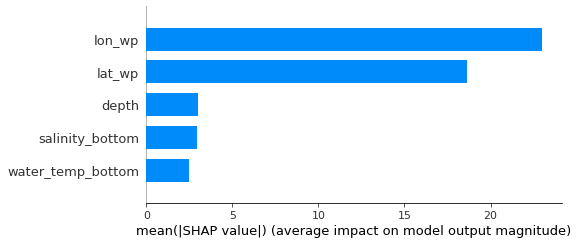

In [29]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)
rf_shap_values = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_values, X_train, plot_type="bar")

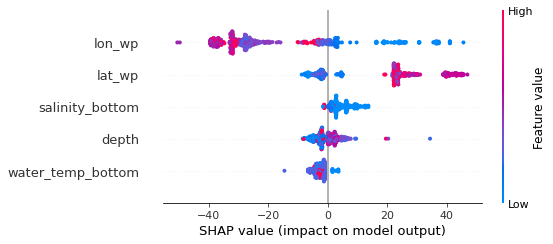

In [30]:
f = plt.figure()
shap.summary_plot(rf_shap_values, X_test)

In [42]:
X = X.drop('year_wp', axis=1)
X100 = shap.utils.sample(X, 100)
explainer_boost = shap.Explainer(model, X100)
shap_values_boost = explainer_boost(X)

 97%|=================== | 7336/7580 [00:14<00:00]       

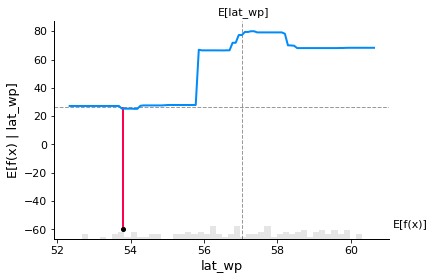

In [43]:
sample_ind = 20
fig,ax = shap.partial_dependence_plot(
    "lat_wp", model.predict, X100, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_boost[sample_ind:sample_ind+1,:])

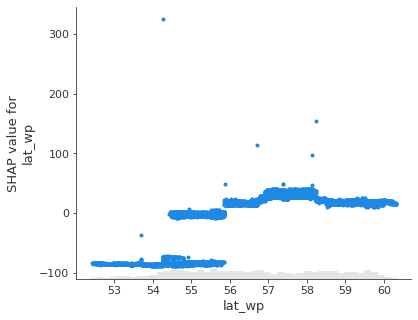

In [46]:
shap.plots.scatter(shap_values_boost[:,"lat_wp"])

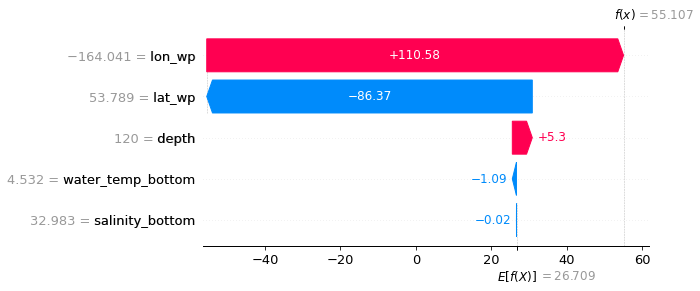

In [47]:
shap.plots.waterfall(shap_values_boost[sample_ind])

Use this if we want to plot alaska idk

(50.0, 61.0)

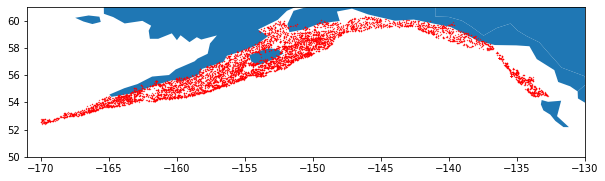

In [78]:

geometry = [Point(xy) for xy in zip(X['lon_wp'], X['lat_wp'])]
gdf = GeoDataFrame(X, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=.1)
plt.xlim([-171, -130])
plt.ylim([50, 61])